In [76]:
from ipywidgets import interact
import time

import matplotlib.pyplot as plt

# for building application
from sequence.app.request_app import RequestApp
from sequence.message import Message

# for building network
from sequence.topology.router_net_topo import RouterNetTopo

## Custom Application

We may now define our custom application. When receiving an entangled memory, we will announce its reception; we will then use the new `AppMessage` class to communicate results to the other node. The receiving node will wait when receiving an entangled memory. Once the classical message is received from the originator, it will release its local memory to be reused. This mimics the behavior of a teleportation operation.

In [77]:
START_TIME = 1e12
NUM_ROUTERS = 7


class TeleportMessage(Message):
    def __init__(self, msg_type, receiver, memo_name: str):
        super().__init__(msg_type, receiver)
        self.memo_name = memo_name

class TeleportApp(RequestApp):
    def __init__(self, node, name, other_name):
        super().__init__(node)
        self.name = name
        self.other_name = other_name
        node.protocols.append(self)
        self.memos_to_measure = {}
        self.entanglement_events = []
        # collect metrics:
        self.latency = 0
        self.count = 0
     
    # Not actally sure where this is used??? why do we not know what MemoryInfo is or where the parameters come from?    
    def get_memory(self, info: "MemoryInfo") -> None:
        """Method to receive entangled memories.

        Will check if the received memory is qualified.
        If it's a qualified memory, the application sets memory to RAW state
        and release back to resource manager.
        The counter of entanglement memories, 'memory_counter', is added.
        Otherwise, the application does not modify the state of memory and
        release back to the resource manager.

        Args:
            info (MemoryInfo): info on the qualified entangled memory.
        """

        # Only interested in working with entangled memories, so we check if the state 
        # of the current recieved memory is entangled or not 
        # if not entangled, immediately returns
        if info.state != "ENTANGLED":
            print("fail")
            return
        #print(type(info))
        
        # Log the simulation time at the point of entanglement
        current_sim_time = self.node.timeline.now()  # This is the current simulation time
        fidelity = info.fidelity  # Fidelity of the entanglement
        
        # Store the data point (time, fidelity) in the list
        self.entanglement_events.append((current_sim_time, fidelity, self.count))

        #if the current memory is in the memory reserve, add that index to the reserve and store it in a variable 
        if info.index in self.memo_to_reserve:
            reservation = self.memo_to_reserve[info.index]
            
            #print(info.fidelity, " = info fidelity")
            print(reservation.fidelity, " = reservation fidelity")
            
            
            # if the node that we are communicating with is the desired recipient and the fidelity is greater than the
            # minimum defined fideliy, we make message for successful entanglement and increment the count of successful ent.
            #print(info.remote_node == reservation.responder and info.fidelity >= reservation.fidelity)
            
            if info.remote_node == reservation.responder and info.fidelity >= reservation.fidelity:
                
                # we are initiator, and want to teleport qubit
                #print("node {} memory {} entangled with other memory {}".format(
                 #   self.node.name, info.index, info.remote_memo))
                
                # record metrics
                if self.count == 0:
                    self.latency = (self.node.timeline.now() - START_TIME) * 1e-12
                self.count += 1
                print(self.count)
                # send message to other node
                message = TeleportMessage(None, self.other_name, info.remote_memo)
                self.node.send_message(self.responder, message)
                
                # reset local memory
                self.node.resource_manager.update(None, info.memory, "RAW")
                
                
            elif info.remote_node == reservation.initiator and info.fidelity >= reservation.fidelity:
                # we are responder, and want to receive qubit
                # need to wait on message from sender to correct entanled memory
                self.memos_to_measure[info.memory.name] = info.memory
                
    def received_message(self, src, message):
        memo_name = message.memo_name
        
        #print("node {} received teleportation message for memory {}".format(
         #   self.node.name, memo_name))
        
        # reset local memory
        memory = self.memos_to_measure.pop(memo_name)
        self.node.resource_manager.update(None, memory, "RAW")

## Building the Simulation

We'll now construct the network and add our applications. This example follows the usual process to ensure that all tools function properly:
1. Create the topology instance for the simulation to manage our network
    - This class will create a simulation timeline
    - This instantiates the Simulation Kernel (see below)
2. Create the simulated network topology. In this case, we are using an external JSON file to specify nodes and their connectivity.
    - This includes specifying hardware parameters in the `set_parameters` function, defined later
    - This instantiates the Hardware, Entanglement Management, Resource Management, and Network Management modules
3. Install custom protocols/applications and ensure all are set up properly
    - This instantiates the Application module
4. Initialize and run the simulation
5. Collect and display the desired metrics

The JSON file specifies that network nodes should be of type `QuantumRouter`, a node type defined by SeQUeNCe. This will automatically create all necessary hardware and protocol instances on the nodes, and the `Topology` class will automatically generate `BSMNode` instances on the quantum channels between such nodes.

To construct an application, we need:
- The node to attach the application to
- The name of the application instance
- The name of the node to teleport qubits to.

We can get a list of all desired application nodes, in this case routers, from the `Topology` class with the `get_nodes_by_type` method. We then set an application on each one.

## Setting parameters

Here we define the `set_parameters` function we used earlier. This function will take a `Topology` as input and change many parameters to desired values. This will be covered in greater detail in workshop 3.

The simulation time limit will be set using the `get_timeline` method.

Quantum memories and detectors are hardware elements, and so parameters are changed by accessing the hardware included with the `QuantumRouter` and `BSMNode` node types. Many complex hardware elements, such as bsm devices or memory arrays, have methods to update parameters for all included hardware elements. This includes `update_memory_params` to change all memories in an array or `update_detector_params` to change all detectors.

We will also set the success probability and swapping degradation of the entanglement swapping protocol. This will be set in the Network management Module (specifically the reservation protocol), as this information is necessary to create and manage the rules for the Resource Management module.

Lastly, we'll update some parameters of the quantum channels. Quantum channels (and, similarly, classical channels) can be accessed from the `Topology` class as the `qchannels` field. Since these are individual hardware elements, we will set the parameters directly.

In [78]:
def set_parameters(topology, simulation_time, attenuation):
    """
    simulation_time: duration of simulation time (s)
    attenuation: attenuation on quantum channels (db/m)
    """
    
    PS_PER_S = 1e12
    
    # set timeline stop time
    topology.get_timeline().stop_time = (simulation_time * PS_PER_S)
    
    # set memory parameters
    MEMO_FREQ = 2e3
    MEMO_EXPIRE = .1
    MEMO_EFFICIENCY = 1
    MEMO_FIDELITY = 0.9349367588934053
    for node in topology.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER):
        memory_array = node.get_components_by_type("MemoryArray")[0]
        memory_array.update_memory_params("frequency", MEMO_FREQ)
        memory_array.update_memory_params("coherence_time", MEMO_EXPIRE)
        memory_array.update_memory_params("efficiency", MEMO_EFFICIENCY)
        memory_array.update_memory_params("raw_fidelity", MEMO_FIDELITY)


    # set detector parameters
    DETECTOR_EFFICIENCY = 0.9
    DETECTOR_COUNT_RATE = 5e7
    DETECTOR_RESOLUTION = 100
    for node in topology.get_nodes_by_type(RouterNetTopo.BSM_NODE):
        bsm = node.get_components_by_type("SingleAtomBSM")[0]
        bsm.update_detectors_params("efficiency", DETECTOR_EFFICIENCY)
        bsm.update_detectors_params("count_rate", DETECTOR_COUNT_RATE)
        bsm.update_detectors_params("time_resolution", DETECTOR_RESOLUTION)
        
    # set entanglement swapping parameters
    SWAP_SUCC_PROB = 0.90
    SWAP_DEGRADATION = 0.99
    for node in topology.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER):
        node.network_manager.protocol_stack[1].set_swapping_success_rate(SWAP_SUCC_PROB)
        node.network_manager.protocol_stack[1].set_swapping_degradation(SWAP_DEGRADATION)
        
    # set quantum channel parameters
    ATTENUATION = attenuation
    QC_FREQ = 1e11
    for qc in topology.qchannels:
        qc.attenuation = ATTENUATION
        qc.frequency = QC_FREQ

In [79]:
def test(r1="router1", r2="router2", sim_time=1.5, qc_atten=1e-5):
    """
    sim_time: duration of simulation time (s)
    qc_atten: quantum channel attenuation (dB/km)
    """
    
    # here, we make a new topology using the configuration JSON file.
    # we then modify some of the simulation parameters of the network.
    
    """
    sim_time: duration of simulation time (s)
    qc_atten: quantum channel attenuation (dB/km)
    """
    
    network_config = "chain_network.json"
    
    # here, we make a new topology using the configuration JSON file.
    # we then modify some of the simulation parameters of the network.
    network_topo = RouterNetTopo(network_config)
    set_parameters(network_topo, sim_time, qc_atten)
    
    # get two end nodes and create application
    start_node_name = r1
    end_node_name = r2
    node1 = node2 = None

    for router in network_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER):
        if router.name == start_node_name:
            node1 = router
        elif router.name == end_node_name:
            node2 = router
            
    start_app_name = "start_app"
    end_app_name = "end_app"
    
    start_app = TeleportApp(node1, start_app_name, end_app_name)
    end_app = TeleportApp(node2, end_app_name, start_app_name)
    
    # run the simulation
    tl = network_topo.get_timeline()
    tl.show_progress = True
    # routers = []
    # for router in network_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER):
    #     routers.append(router)
    # for i in range(NUM_ROUTERS):
    #     for j in range(NUM_ROUTERS):
    #         if j != i:
    #             if i > j:
    #                 routers[i].network_manager.protocol_stack[0].add_forwarding_rule("router" + str(j), "router" + str(i-1))
    #             if i < j:
    #                 routers[i].network_manager.protocol_stack[0].add_forwarding_rule("router" + str(j), "router" + str(i+1))
    tl.init()
    #reqesting what
    #node1.network_manager.request(r2, 1e12, 1e14, 20, 0.9)
    start_app.start(end_node_name, START_TIME, 2e12, 10, 0.9)
    tick = time.time()
    tl.run()
    
    #print("\n")
    #print("Execution time: {:.3f} seconds".format(time.time() - tick))
    
    #print("\n")
    #print("Latency: {:.3f} s".format(start_app.latency))
    #print("Number of entangled memories:", start_app.count)
    #print("Average throughput: {:.3f} pairs/s".format(
       #start_app.count / (sim_time - (START_TIME * 1e-12))))
    return([start_app.latency,start_app.count,(sim_time - (START_TIME * 1e-12)),start_app, end_app])

    
   

## Running the Simulation

All that is left is to run the simulation with user input. We'll specify:

    sim_time: duration of simulation time (s)
    qc_atten: attenuation on quantum channels (dB/m)

Note that different hardware parameters or network topologies may cause the simulation to run for a very long time.

0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9cution time: 0:00:03.064354;     simulation time: 0:00:01.547500 / 5:33:20  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


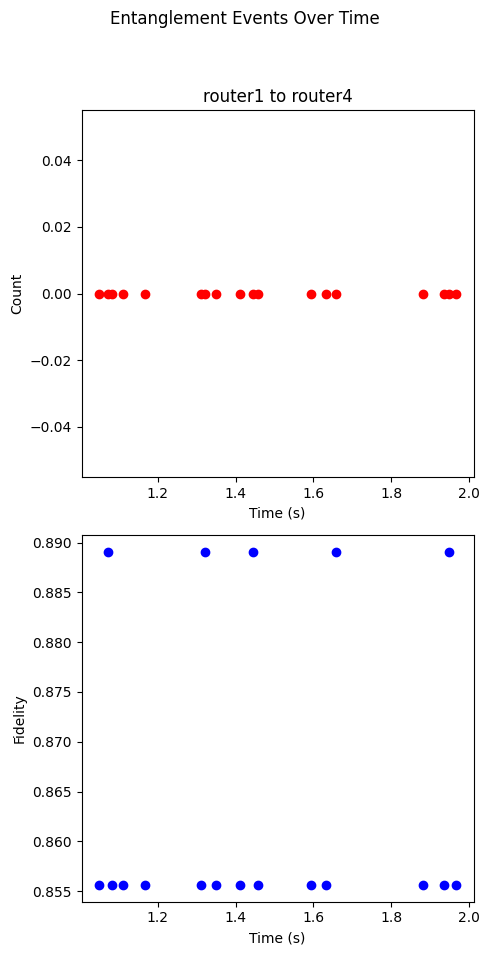

0.9  = reservation fidelity  simulation time: 0:00:01.001500 / 5:33:20
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity003;     simulation time: 0:00:01.273000 / 5:33:20
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9cution time: 0:00:06.347562;     simulation time: 0:00:01.571000 / 5:33:20  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity981;     simulation time: 0:00:01.839500 / 5:33:20
0.9  = reservation fidelity
0.9  = reservation fidelity
0.9  = reservation fidelity
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
         12022397 function calls (11813131 primitive calls) in 11.434 seconds

   Or

In [80]:
import matplotlib.pyplot as plt
from line_profiler import profile
import cProfile

@profile
def run_simulation_and_plot(router_pairs, sim_time, qc_atten):
    num_pairs = len(router_pairs)
    
    # Create a figure with 2 rows and enough columns for all router pairs
    fig, axes = plt.subplots(nrows=2, ncols=num_pairs, figsize=(num_pairs * 5, 10))
    fig.suptitle('Entanglement Events Over Time')

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    for index, (r1, r2) in enumerate(router_pairs):
        
        results = test(r1, r2, sim_time, qc_atten)
        # Unpack results
        latency, count, adjusted_sim_time, start_app, end_app = results

        # Combine entanglement events from both apps
        all_entanglement_events = start_app.entanglement_events + end_app.entanglement_events

        # Sort events by time if they are not already
        all_entanglement_events.sort(key=lambda x: x[0])

        # Unpack your data into separate lists for plotting
        times, fidelities, counts = zip(*all_entanglement_events)

        # Convert simulation times from picoseconds to seconds, if needed
        times = [t * 1e-12 for t in times]

        # Plot count over time for the current router pair in the top row
        ax_count = axes[index]
        ax_count.scatter(times, counts, c='red', label='Count over Time')
        ax_count.set_title(f'{r1} to {r2}')
        ax_count.set_xlabel('Time (s)')
        ax_count.set_ylabel('Count')
        
        # Plot fidelity over time for the current router pair in the bottom row
        ax_fidelity = axes[index + num_pairs]
        ax_fidelity.scatter(times, fidelities, c='blue', label='Fidelity over Time')
        ax_fidelity.set_xlabel('Time (s)')
        ax_fidelity.set_ylabel('Fidelity')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle
    plt.show()

# Router combinations excluding same router pairings
router1 = "router1"  # Define the router1 variable
router4 = "router4"  # Define the router4 variable
router_pairs = [[router1, router4]]  # Use the defined variables in the router_pairs list

# Run simulations for all pairs
#run_simulation_and_plot(router_pairs, sim_time=20000, qc_atten=1e-5)
#cProfile.run('test(router1, router4, 20000, 1e-5)')
num_routers = 5
#router_pairs = [(f"router{i}", f"router{j}") for i in range(1, num_routers+1) for j in range(1, num_routers+1) if i != j]
router_pairs = [["router1","router4"]]
# Run simulations for all pairs
run_simulation_and_plot(router_pairs, sim_time=20000, qc_atten=1e-5)
cProfile.run('test(router1, router4, 20000, 1e-5)')